In [ ]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import pandas as pd

import torch

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)
from collections import defaultdict


from sklearn.preprocessing import normalize
from PIL import Image
from CLIP.clip import clip

In [11]:
from prompts.prompts_taxonomia import prompts_Animal, prompts_Order_stingray, prompts_Order_shark, prompts_Family_cacharhiniformes, prompts_Our_Name_scyliorhinidae, prompts_Our_Name_triakidae
from prompts.prompts_general import prompts_Animal, prompts_Order, prompts_Family, prompts_Our_Name


In [12]:
data = [
    ['bocanegra','galeus melastomus','blackmouth catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['cazon','galeorhinus galeus','tope shark','carcharhiniformes','triakidae','shark'],
    ['cerdo_marino','oxynotus centrina','angular roughshark','squaliformes','oxynotidae','shark'],
    ['musola','mustelus mustelus','smouth-hound','carcharhiniformes','triakidae','shark'],
    ['pintarroja','scyliorhinus canicula','small-spotted catshark','carcharhiniformes','scyliorhinidae','shark'],
    ['santiaguesa','raja undulata','undulate ray','rajiformes','rajidae','stingray'],
    ['tembladera','torpedo marmorata','spotted torpedo','torpediniformes','torpedinidae','stingray'],
]

df = pd.DataFrame(data, columns=['Our_Name','Scientific_Name', 'Common_Name', 'Order', 'Family','Animal']) 
df

,Our_Name,Scientific_Name,Common_Name,Order,Family,Animal
0,bocanegra,galeus melastomus,blackmouth catshark,carcharhiniformes,scyliorhinidae,shark
1,cazon,galeorhinus galeus,tope shark,carcharhiniformes,triakidae,shark
2,cerdo_marino,oxynotus centrina,angular roughshark,squaliformes,oxynotidae,shark
3,musola,mustelus mustelus,smouth-hound,carcharhiniformes,triakidae,shark
4,pintarroja,scyliorhinus canicula,small-spotted catshark,carcharhiniformes,scyliorhinidae,shark
5,santiaguesa,raja undulata,undulate ray,rajiformes,rajidae,stingray
6,tembladera,torpedo marmorata,spotted torpedo,torpediniformes,torpedinidae,stingray


In [13]:
def resize_con_padding(img, target_size=(224, 224), fill_color=(255, 255, 255)):
    """
    Reescala la imagen manteniendo el aspecto y la centra en un lienzo cuadrado con padding.
    
    Args:
        img: PIL.Image
        target_size: tamaño final (ancho, alto)
        fill_color: color del fondo (por defecto blanco)
    
    Returns:
        PIL.Image redimensionada sin distorsión
    """
    img_ratio = img.width / img.height
    target_ratio = target_size[0] / target_size[1]

    if img_ratio > target_ratio:
        new_width = target_size[0]
        new_height = round(new_width / img_ratio)
    else:
        new_height = target_size[1]
        new_width = round(new_height * img_ratio)


    img_resized = img.resize((new_width, new_height), resample=Image.BICUBIC)


    new_img = Image.new("RGB", target_size, fill_color)
    upper_left = ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2)
    new_img.paste(img_resized, upper_left)

    return new_img


In [14]:

main_folder = r'D:\datasets\ELASMOBRANC\data'

image_paths_shark = []
labels_shark = []
exclude_classes=[]

for class_name in os.listdir(main_folder):
    if any(excl in class_name.lower() for excl in exclude_classes):
        continue  
    class_folder = os.path.join(main_folder, class_name)
    if os.path.isdir(class_folder):
        for item_name in os.listdir(class_folder):
            item_path = os.path.join(class_folder, item_name)
            if os.path.isfile(item_path):
                image_paths_shark.append(item_path)
                labels_shark.append(class_name)

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-L/14', device)

imagens_tensor = []
for r in image_paths_shark:
    image = Image.open(r)
    image = resize_con_padding(image) 
    image_input = preprocess(image).unsqueeze(0).to(device)
    imagens_tensor.append(image_input)
    
batch_images = torch.cat(imagens_tensor, dim=0)
with torch.no_grad():
  feature_image = model.encode_image(batch_images)[:,0,:]

In [15]:
all_prompts = {
    "Animal": prompts_Animal,
    "Order_raya": prompts_Order_stingray,
    "Order_shark": prompts_Order_shark,
    "Family_cacharhiniformes": prompts_Family_cacharhiniformes,
    "Our_Name_scyliorhinidae": prompts_Our_Name_scyliorhinidae,
    "Our_Name_triakidae": prompts_Our_Name_triakidae,
}

encoded_dict = {}

for group_key, prompt_dict in all_prompts.items():
    for key, descriptions in prompt_dict.items():
        if key not in encoded_dict:
            encoded_dict[key] = []
        for desc in descriptions:
            text_input = clip.tokenize(desc).to(device)
            with torch.no_grad():
                text_feat = model.encode_text(text_input)
            text_feat /= text_feat.norm(dim=-1, keepdim=True)

            encoded_dict[key].append({
                "description": desc,
                "text_embedding": text_feat,
                "group": group_key
            })



In [16]:
df_clean = df[['Animal','Order','Family','Our_Name']]
df_taxonomy = df_clean.sort_values(by=['Animal','Order','Family','Our_Name']).reset_index(drop=True)
df_taxonomy


,Animal,Order,Family,Our_Name
0,shark,carcharhiniformes,scyliorhinidae,bocanegra
1,shark,carcharhiniformes,scyliorhinidae,pintarroja
2,shark,carcharhiniformes,triakidae,cazon
3,shark,carcharhiniformes,triakidae,musola
4,shark,squaliformes,oxynotidae,cerdo_marino
5,stingray,rajiformes,rajidae,santiaguesa
6,stingray,torpediniformes,torpedinidae,tembladera


In [17]:
orders_shark = df_taxonomy.loc[df_taxonomy["Animal"] == "shark", "Order"].unique().tolist()
orders_shark

['carcharhiniformes', 'squaliformes']

## Standard CLIP prompt-based classification without taxonomic strategy

In [18]:
levels=["Animal","Order","Family","Our_Name"]
label_animal=["shark","stingray"]

final_results=[]

for image in feature_image:
    result_image=[]
    
    img_norm = image / image.norm(dim=-1, keepdim=True)
    
    shark_emb = encoded_dict["shark"][0]["text_embedding"].flatten()
    stingray_emb = encoded_dict["stringray"][0]["text_embedding"].flatten()
    
    sims_animal = (img_norm @ torch.stack([shark_emb, stingray_emb]).T).squeeze(0)
    result_image.append(label_animal[sims_animal.argmax().item()])
    
    i=0
    while i<len(levels)-1:     
        next_level = df_taxonomy.loc[df_taxonomy[levels[i]] == result_image[-1], levels[i+1]].unique().tolist()
        if len(next_level) == 1:
            result_image.append(next_level[0])
            i += 1
            continue         
        embs_text = torch.stack([encoded_dict[k][0]["text_embedding"].flatten() for k in next_level])        
        sims = (img_norm @ embs_text.T).squeeze(0)
        result_image.append(next_level[sims.argmax().item()])
        i += 1

    final_results.append(result_image)
    

-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



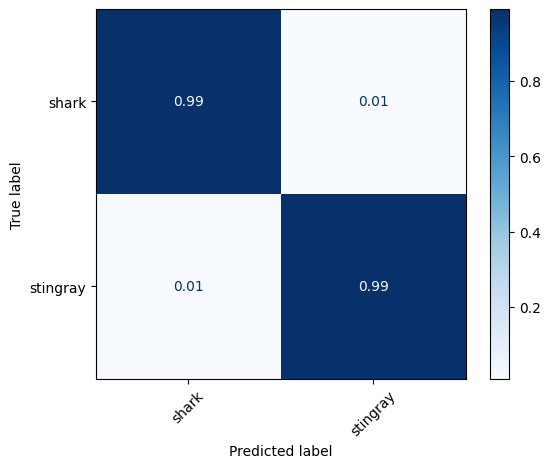


-----Order-----
Accuracy balanced: 0.8277
Accuracy: 0.8214

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.99      0.82      0.89       272
     squaliformes       0.38      0.86      0.53        36
       rajiformes       0.86      0.83      0.85        90
  torpediniformes       0.74      0.80      0.77        50

         accuracy                           0.82       448
        macro avg       0.74      0.83      0.76       448
     weighted avg       0.89      0.82      0.84       448



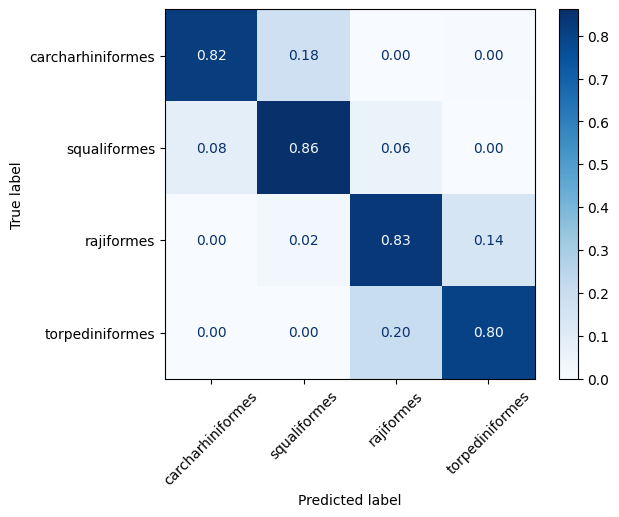


-----Family-----
Accuracy balanced: 0.7791
Accuracy: 0.7545

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.91      0.73      0.81       158
     triakidae       0.78      0.67      0.72       114
    oxynotidae       0.38      0.86      0.53        36
       rajidae       0.86      0.83      0.85        90
  torpedinidae       0.74      0.80      0.77        50

      accuracy                           0.75       448
     macro avg       0.73      0.78      0.73       448
  weighted avg       0.81      0.75      0.77       448



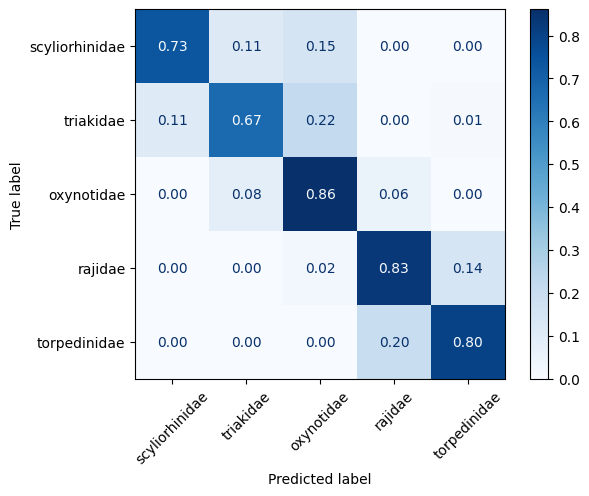


-----Our_Name-----
Accuracy balanced: 0.6210
Accuracy: 0.6049

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.26      0.51      0.35        37
       cazon       0.70      0.37      0.48        38
cerdo_marino       0.38      0.86      0.53        36
      musola       0.56      0.57      0.56        76
  pintarroja       0.89      0.40      0.56       121
 santiaguesa       0.86      0.83      0.85        90
  tembladera       0.74      0.80      0.77        50

    accuracy                           0.60       448
   macro avg       0.63      0.62      0.58       448
weighted avg       0.70      0.60      0.61       448



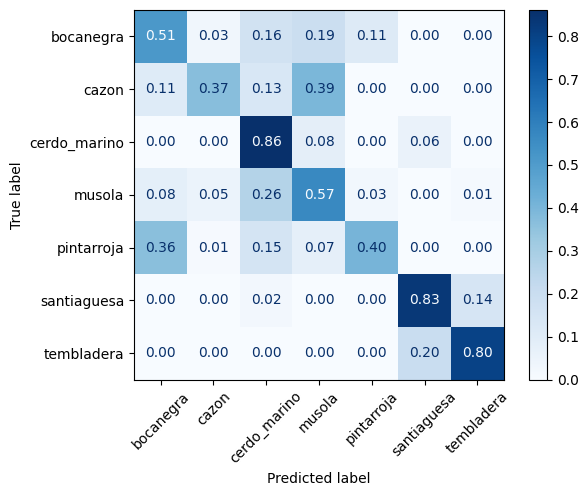

In [19]:
labels_shark_True = [label.lower() for label in labels_shark]

for v, lv in enumerate(levels):    
    col = [row[v] for row in final_results]
    name_to_family = dict(zip(df['Our_Name'], df[lv]))  
    labels_shark_adt = [name_to_family[name] for name in labels_shark_True]
    print("-----"+lv+"-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), zero_division=0)
    print("\nClassification Report:\n", report)

    
    cm = confusion_matrix(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())
    disp.plot(cmap='Blues', xticks_rotation=45, values_format=".2f") 
    plt.show()

    print()

    
    
    

## Taxonomy-aware classification with a general aggregation strategy

In [22]:
all_prompts = {
    "Animal": prompts_Animal,
    "Order": prompts_Order,
    "Family": prompts_Family,
    "Our_Name": prompts_Our_Name,
}

encoded_dict_general = {}

model.eval()

for group_key, prompt_dict in all_prompts.items():
    encoded_dict_general[group_key] = defaultdict(list)
    for key, descriptions in prompt_dict.items():
        if not descriptions:
            continue
        text_inputs = clip.tokenize(descriptions).to(device)
        with torch.no_grad():
            text_feats = model.encode_text(text_inputs)
            text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
        for desc, feat in zip(descriptions, text_feats):
            encoded_dict_general[group_key][key].append({
                "description": desc,
                "text_embedding": feat.detach().clone()
            })
    encoded_dict_general[group_key] = dict(encoded_dict_general[group_key])


In [23]:
stacked_by_level = {}

for lvl, d in encoded_dict_general.items():
    all_embs = []
    for k, lst in d.items():
        for x in lst:
            all_embs.append(x["text_embedding"].flatten())
    stacked_by_level[lvl] = torch.stack(all_embs) if all_embs else torch.empty(0)

In [24]:
final_results = []

levels = ["Animal","Order","Family","Our_Name"]
labels_by_level = {
 'Animal': ['shark', 'stingray'],
 'Order': ['carcharhiniformes', 'squaliformes', 'torpediniformes', 'rajiformes'],
 'Family': ['scyliorhinidae', 'triakidae', 'oxynotidae', 'rajidae', 'torpedinidae'],
 'Our_Name': ['bocanegra', 'cazon', 'cerdo_marino', 'musola', 'pintarroja', 'santiaguesa', 'tembladera']
}

index_maps = {lvl: {lab: i for i, lab in enumerate(labels_by_level[lvl])} for lvl in levels}

species_positions = [
    [index_maps[lvl][df.iloc[r][lvl]] for lvl in levels]
    for r in range(len(df))
]
n_cols = len(species_positions[0])

for image in feature_image:
    image_tax = []
    sims_image = []
    img_norm = image / image.norm(dim=-1, keepdim=True)
    for level in levels:
        mat = stacked_by_level[level]
        sims = img_norm @ mat.T
        sims_image.append(sims)

    for c in range(n_cols):
        scores = []
        for row in species_positions:
            pos = row[:c+1]
            total = sum(sims_image[i][pos[i]] for i in range(c+1))
            scores.append(total)
        scores = torch.stack(scores)
        idx_best = int(torch.argmax(scores).item())
        image_tax.append(df.iloc[idx_best][levels[c]])

    final_results.append(image_tax)


-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



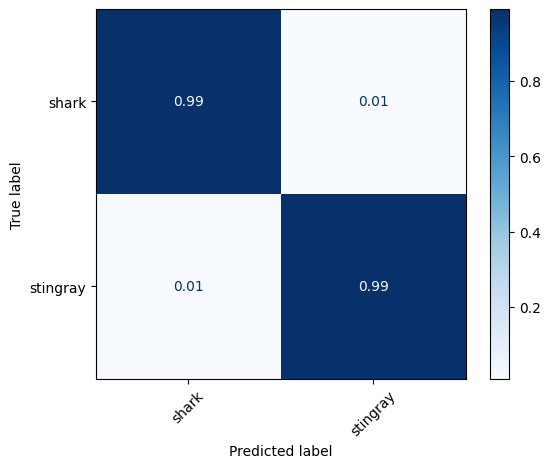


-----Order-----
Accuracy balanced: 0.8267
Accuracy: 0.8192

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.99      0.81      0.89       272
     squaliformes       0.37      0.86      0.52        36
       rajiformes       0.87      0.83      0.85        90
  torpediniformes       0.73      0.80      0.76        50

         accuracy                           0.82       448
        macro avg       0.74      0.83      0.76       448
     weighted avg       0.89      0.82      0.84       448



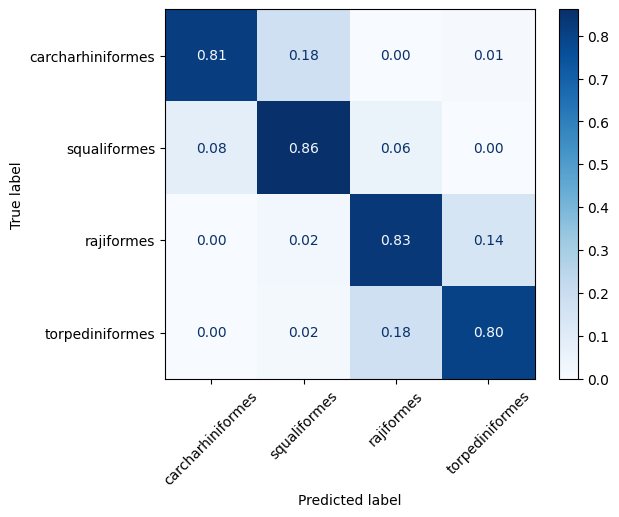


-----Family-----
Accuracy balanced: 0.7806
Accuracy: 0.7857

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.88      0.77      0.82       158
     triakidae       0.73      0.79      0.76       114
    oxynotidae       0.50      0.69      0.58        36
       rajidae       0.89      0.83      0.86        90
  torpedinidae       0.76      0.82      0.79        50

      accuracy                           0.79       448
     macro avg       0.75      0.78      0.76       448
  weighted avg       0.80      0.79      0.79       448



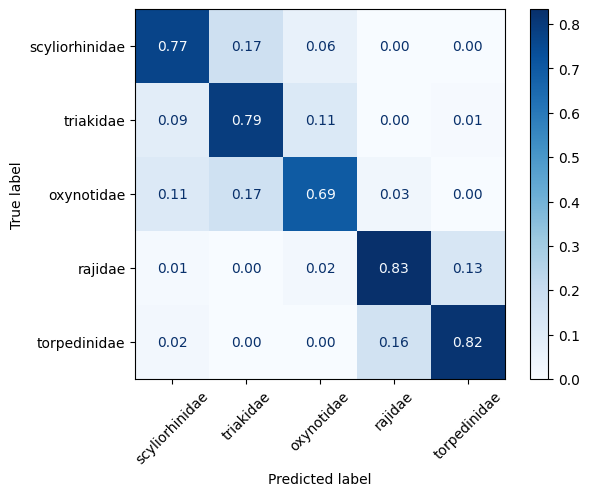


-----Our_Name-----
Accuracy balanced: 0.6117
Accuracy: 0.5781

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.26      0.62      0.36        37
       cazon       0.37      0.50      0.43        38
cerdo_marino       0.71      0.67      0.69        36
      musola       0.47      0.64      0.54        76
  pintarroja       0.86      0.21      0.33       121
 santiaguesa       0.85      0.92      0.88        90
  tembladera       0.88      0.72      0.79        50

    accuracy                           0.58       448
   macro avg       0.63      0.61      0.57       448
weighted avg       0.69      0.58      0.57       448



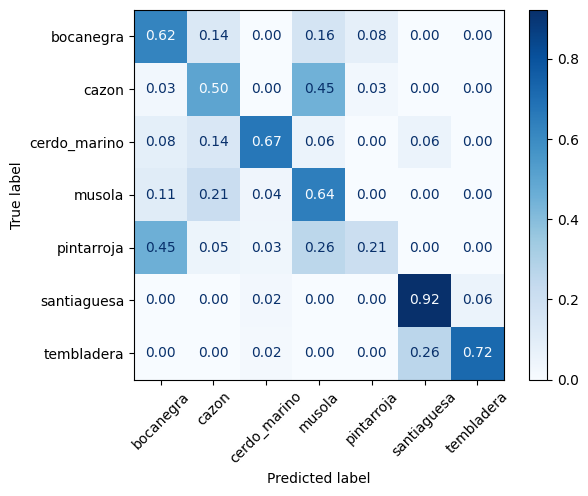

In [25]:
labels_shark_True = [label.lower() for label in labels_shark]

for v, lv in enumerate(levels):    
    col = [row[v] for row in final_results]
    name_to_family = dict(zip(df['Our_Name'], df[lv]))  
    labels_shark_adt = [name_to_family[name] for name in labels_shark_True]
    print("-----"+lv+"-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), zero_division=0)
    print("\nClassification Report:\n", report)

    
    cm = confusion_matrix(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())
    disp.plot(cmap='Blues', xticks_rotation=45, values_format=".2f")  
    plt.show()

    print()

    

## Standard CLIP prompt-based classification without taxonomic strategy

In [26]:
final_results = []

levels = ["Animal","Order","Family","Our_Name"]
labels_by_level = {
 'Animal': ['shark', 'stingray'],
 'Order': ['carcharhiniformes', 'squaliformes', 'torpediniformes', 'rajiformes'],
 'Family': ['scyliorhinidae', 'triakidae', 'oxynotidae', 'rajidae', 'torpedinidae'],
 'Our_Name': ['bocanegra', 'cazon', 'cerdo_marino', 'musola', 'pintarroja', 'santiaguesa', 'tembladera']
}

index_maps = {lvl: {lab: i for i, lab in enumerate(labels_by_level[lvl])} for lvl in levels}

species_positions = [
    [index_maps[lvl][df.iloc[r][lvl]] for lvl in levels]
    for r in range(len(df))
]
n_cols = len(species_positions[0])

for image in feature_image:
    image_tax = []
    sims_image = []
    img_norm = image / image.norm(dim=-1, keepdim=True)
    for level in levels:
        mat = stacked_by_level[level]
        sims = img_norm @ mat.T
        sims_image.append(sims)
        
    for n, s in enumerate(sims_image):
        idx_best = int(torch.argmax(s).item())
        best_label = labels_by_level[levels[n]][idx_best]
        image_tax.append(best_label)

    final_results.append(image_tax)


-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



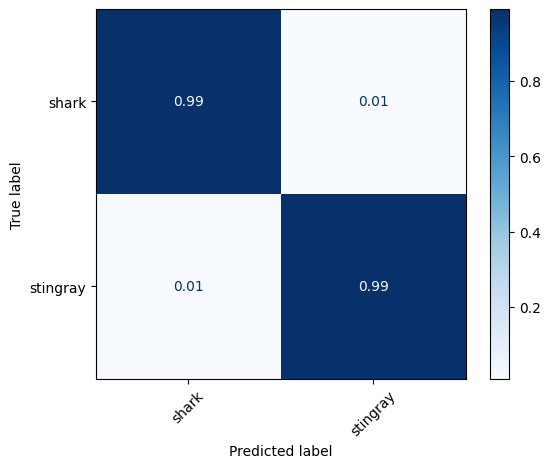


-----Order-----
Accuracy balanced: 0.7858
Accuracy: 0.7879

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.99      0.78      0.87       272
     squaliformes       0.33      0.78      0.46        36
       rajiformes       0.79      0.82      0.80        90
  torpediniformes       0.73      0.76      0.75        50

         accuracy                           0.79       448
        macro avg       0.71      0.79      0.72       448
     weighted avg       0.86      0.79      0.81       448



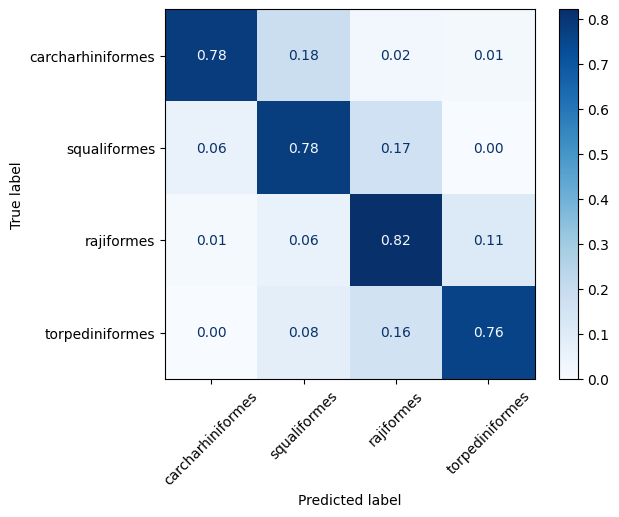


-----Family-----
Accuracy balanced: 0.6999
Accuracy: 0.7411

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.87      0.74      0.80       158
     triakidae       0.64      0.82      0.72       114
    oxynotidae       0.43      0.36      0.39        36
       rajidae       0.90      0.73      0.81        90
  torpedinidae       0.67      0.84      0.74        50

      accuracy                           0.74       448
     macro avg       0.70      0.70      0.69       448
  weighted avg       0.76      0.74      0.74       448



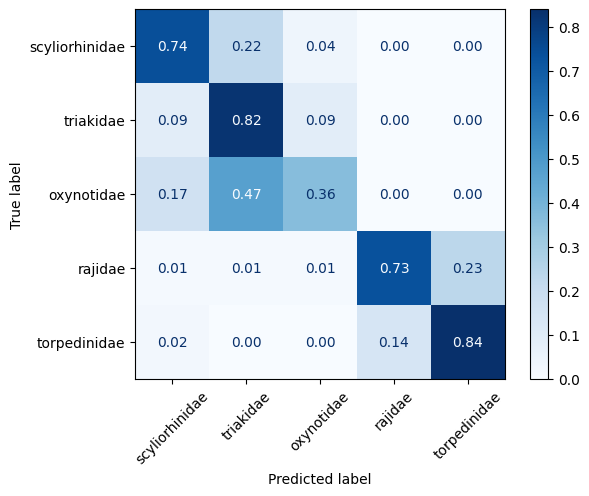


-----Our_Name-----
Accuracy balanced: 0.5074
Accuracy: 0.5000

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.24      0.57      0.34        37
       cazon       0.27      0.42      0.33        38
cerdo_marino       0.68      0.42      0.52        36
      musola       0.40      0.61      0.48        76
  pintarroja       0.95      0.16      0.27       121
 santiaguesa       0.70      0.94      0.80        90
  tembladera       0.96      0.44      0.60        50

    accuracy                           0.50       448
   macro avg       0.60      0.51      0.48       448
weighted avg       0.67      0.50      0.48       448



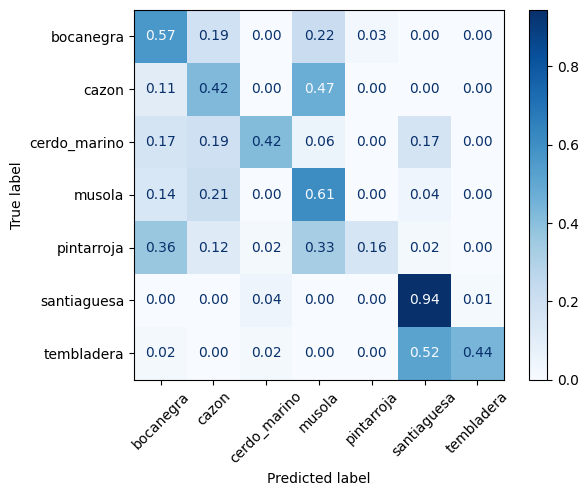

In [27]:
labels_shark_True = [label.lower() for label in labels_shark]

for v, lv in enumerate(levels):    
    col = [row[v] for row in final_results]
    name_to_family = dict(zip(df['Our_Name'], df[lv]))  
    labels_shark_adt = [name_to_family[name] for name in labels_shark_True]
    print("-----"+lv+"-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), zero_division=0)
    print("\nClassification Report:\n", report)

    
    cm = confusion_matrix(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())
    disp.plot(cmap='Blues', xticks_rotation=45, values_format=".2f")  
    plt.show()

    print()

    

## Normal name-based classification 

In [28]:
import torch

final_results = []

levels = ["Animal","Order","Family","Our_Name","Scientific_Name","Common_Name"]
labels_by_level = {
    "Animal": ["shark", "stingray"],
    "Order": ["carcharhiniformes", "squaliformes", "torpediniformes", "rajiformes"],
    "Family": ["scyliorhinidae", "triakidae", "oxynotidae", "rajidae", "torpedinidae"],
    "Our_Name": ["bocanegra", "cazon", "cerdo_marino", "musola", "pintarroja", "santiaguesa", "tembladera"],
    "Scientific_Name": [
        "galeus melastomus",
        "galeorhinus galeus",
        "oxynotus centrina",
        "mustelus mustelus",
        "scyliorhinus canicula",
        "raja undulata",
        "torpedo marmorata"
    ],
    "Common_Name": [
        "blackmouth catshark",
        "tope shark",
        "angular roughshark",
        "smouth-hound",
        "small-spotted catshark",
        "undulate ray",
        "spotted torpedo"
    ]
}

for image in feature_image:
    result_image = []
    img_norm = image / image.norm(dim=-1, keepdim=True)
    for level in levels:
        text_inputs = clip.tokenize(labels_by_level[level]).to(device)
        with torch.no_grad():
            feature_text = model.encode_text(text_inputs)
        feature_text /= feature_text.norm(dim=-1, keepdim=True)
        
        sims = (img_norm @ feature_text.T).squeeze(0)
        result_image.append(labels_by_level[level][sims.argmax().item()])
    final_results.append(result_image)


-----Animal-----
Accuracy balanced: 0.9880
Accuracy: 0.9888

Classification Report:
               precision    recall  f1-score   support

       shark       0.99      0.99      0.99       308
    stingray       0.98      0.99      0.98       140

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



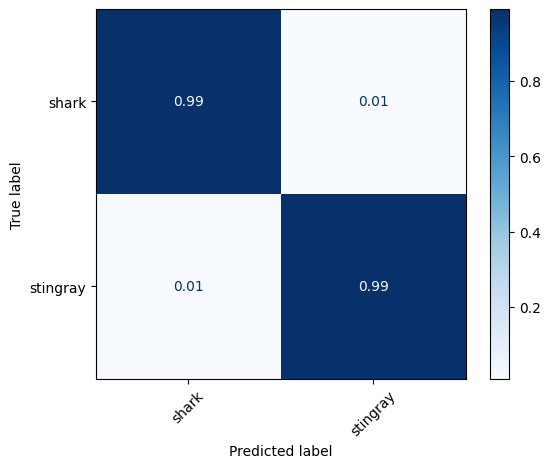


-----Order-----
Accuracy balanced: 0.3661
Accuracy: 0.6987

Classification Report:
                    precision    recall  f1-score   support

carcharhiniformes       0.75      1.00      0.86       272
     squaliformes       0.00      0.00      0.00        36
       rajiformes       0.66      0.44      0.53        90
  torpediniformes       1.00      0.02      0.04        50

         accuracy                           0.70       448
        macro avg       0.60      0.37      0.36       448
     weighted avg       0.70      0.70      0.63       448



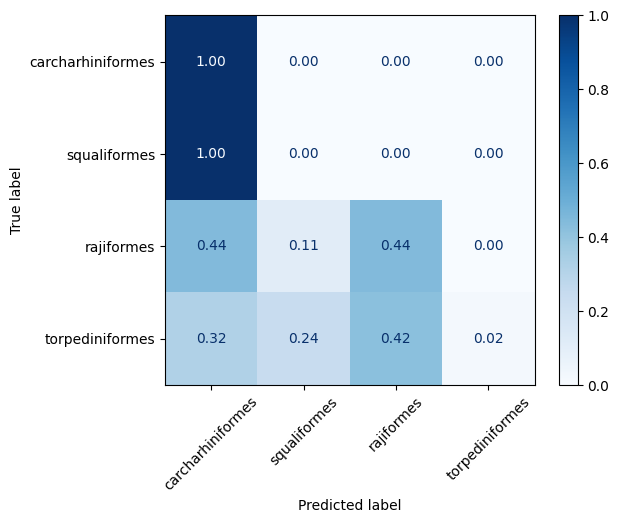


-----Family-----
Accuracy balanced: 0.1771
Accuracy: 0.1763

Classification Report:
                 precision    recall  f1-score   support

scyliorhinidae       0.29      0.13      0.18       158
     triakidae       0.29      0.32      0.31       114
    oxynotidae       0.17      0.03      0.05        36
       rajidae       0.00      0.00      0.00        90
  torpedinidae       0.08      0.40      0.14        50

      accuracy                           0.18       448
     macro avg       0.17      0.18      0.13       448
  weighted avg       0.20      0.18      0.16       448



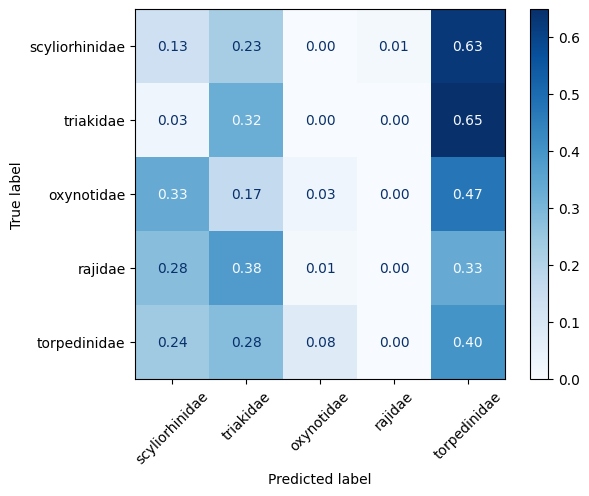


-----Our_Name-----
Accuracy balanced: 0.1401
Accuracy: 0.1094

Classification Report:
               precision    recall  f1-score   support

   bocanegra       0.00      0.00      0.00        37
       cazon       0.00      0.00      0.00        38
cerdo_marino       0.10      0.69      0.18        36
      musola       0.10      0.24      0.14        76
  pintarroja       0.23      0.05      0.08       121
 santiaguesa       0.00      0.00      0.00        90
  tembladera       0.00      0.00      0.00        50

    accuracy                           0.11       448
   macro avg       0.06      0.14      0.06       448
weighted avg       0.09      0.11      0.06       448



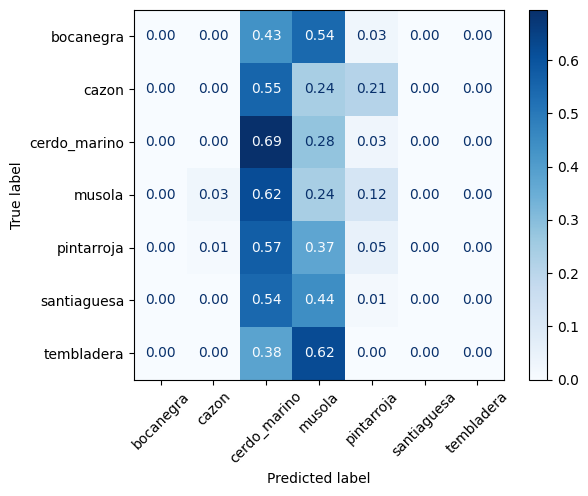


-----Scientific_Name-----
Accuracy balanced: 0.1301
Accuracy: 0.1451

Classification Report:
                        precision    recall  f1-score   support

    galeus melastomus       0.01      0.03      0.02        37
   galeorhinus galeus       0.00      0.00      0.00        38
    oxynotus centrina       0.00      0.00      0.00        36
    mustelus mustelus       0.08      0.11      0.09        76
scyliorhinus canicula       0.12      0.14      0.13       121
        raja undulata       0.67      0.18      0.28        90
    torpedo marmorata       0.26      0.46      0.33        50

             accuracy                           0.15       448
            macro avg       0.16      0.13      0.12       448
         weighted avg       0.21      0.15      0.14       448



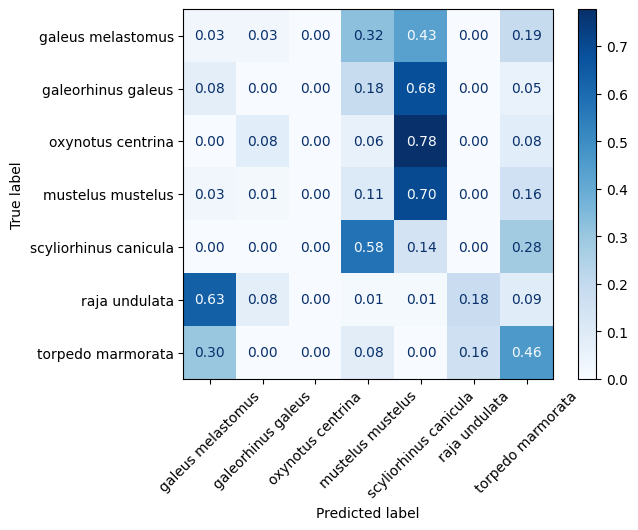


-----Common_Name-----
Accuracy balanced: 0.3732
Accuracy: 0.5067

Classification Report:
                         precision    recall  f1-score   support

   blackmouth catshark       0.14      0.11      0.12        37
            tope shark       0.50      0.13      0.21        38
    angular roughshark       0.25      0.47      0.33        36
          smouth-hound       0.00      0.00      0.00        76
small-spotted catshark       0.54      0.97      0.69       121
          undulate ray       0.68      0.93      0.79        90
       spotted torpedo       0.00      0.00      0.00        50

              accuracy                           0.51       448
             macro avg       0.30      0.37      0.30       448
          weighted avg       0.36      0.51      0.40       448



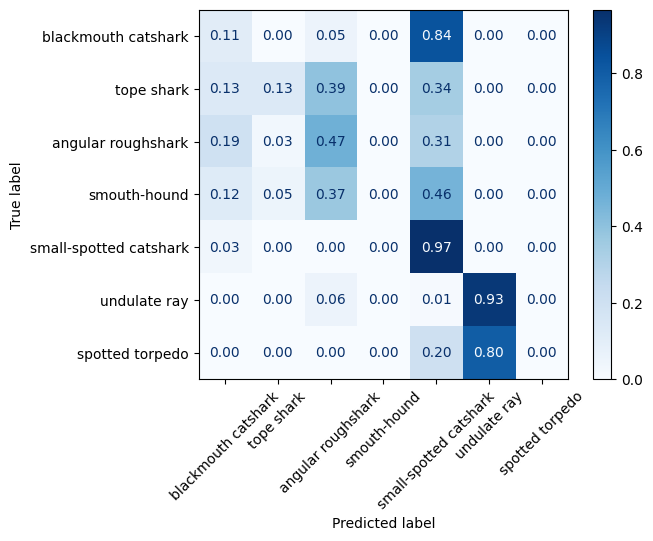

In [29]:
labels_shark_True = [label.lower() for label in labels_shark]

for v, lv in enumerate(levels):    
    col = [row[v] for row in final_results]
    name_to_family = dict(zip(df['Our_Name'], df[lv]))  
    labels_shark_adt = [name_to_family[name] for name in labels_shark_True]
    print("-----"+lv+"-----")
    acc = balanced_accuracy_score(labels_shark_adt, col)
    print(f"Accuracy balanced: {acc:.4f}")
    acc = accuracy_score(labels_shark_adt, col)
    print(f"Accuracy: {acc:.4f}")
    report = classification_report(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), zero_division=0)
    print("\nClassification Report:\n", report)

    
    cm = confusion_matrix(labels_shark_adt, col, labels=df[lv].drop_duplicates().to_list(), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df[lv].drop_duplicates().to_list())
    disp.plot(cmap='Blues', xticks_rotation=45, values_format=".2f")  
    plt.show()

    print()

    